# What Makes The Best Tennis Player?

Author: Preeti Bairi

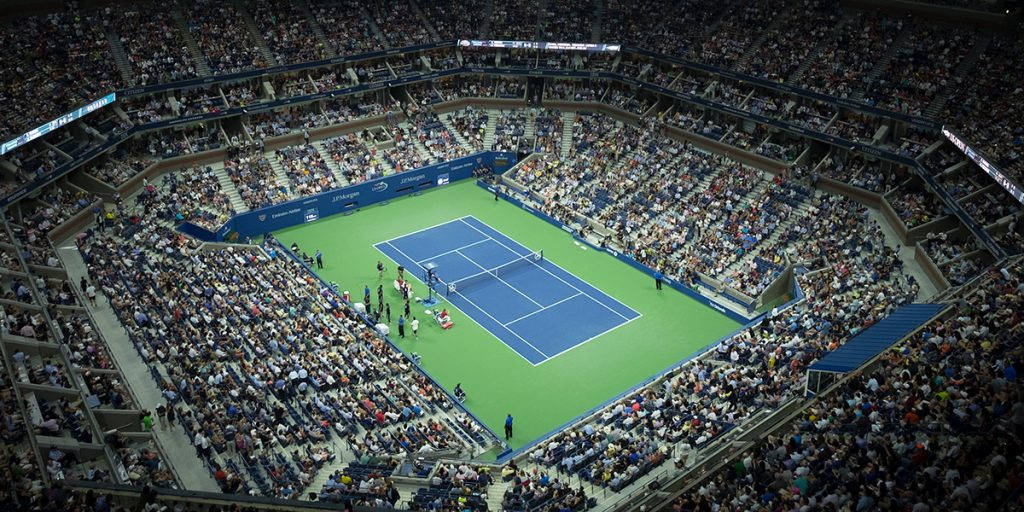


## Introduction: 

Sports are an entertainment industry that has flourished over the past few decades, with more and more individuals making careers out of professional sports. Tennis is a racquet sport where players hit a rubber ball back and forth over a net to score points. Each set in a tennis match consists of 6 games, with each game won by gaining 4 points against your opponent. In regular tournaments, players must win 2 of 3 sets to win a match while in the grand slams, women play the best of 3 sets while men play best of 5 sets. 

Although tennis is a relatively popular sport, there is a lot less statistical analysis on the sport compared to more commercial sports in the United States such as basketball or football. As someone who has been playing Tennis her whole life, I was interested in observing and analyzing what attributes are common between the best tennis players. The research question here is “What makes a tennis player the best?”This tutorial will go through the data life cycle of data collection, data processing, exploratory analysis and visualization, hypothesis testing and machine learning, and conclusions with this research question in mind. 

## Outline:
1. Data Collection
2. Data Processing
3. Data Analysis
4. Hypothesis Testing and Machine Learning
5. Conclusions and Insights

### Part 1: Data Collection

These are all the libraries that we will need going forward in this project. 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn import linear_model
from sklearn import model_selection
from statsmodels import api as sm

In this first step, we are going to scrape data from this website: https://www.atptour.com/ is the official site of men’s professional tennis. We want to observe how different statistics can affect the ranking of the player. 

We first scrape information from https://www.atptour.com/en/rankings/singles  to get an order of the players by their rank with additional information on factors such as their age. This page however does not contain statistics about skills or match play. To get information on the stats for each player, we want to loop through the ranking list and scrape data from their player statistics page on the serves and returns records. 

Here a resource for more information on scraping in python: https://realpython.com/python-web-scraping-practical-introduction/

In [2]:
ret_arr = []
serv_arr = []
height_arr = []
weight_arr = []

def scrape_ranking_list(num_players): #scraping the ranking list
    N = num_players
    page_ranking = requests.get('https://www.atpworldtour.com/en/rankings/singles?rankDate=2020-03-16&rankRange=1-' \
    + str(N))
    ranking = BeautifulSoup(page_ranking.content, 'html.parser')
    
    return ranking

def scrape_reg_stats(ranking): #scraping a table with regular statistics (age, tournaments played)
    table_body = ranking.find('tbody')
    table_rows = table_body.find_all('tr')

    res = []
    for tr in table_rows:
        td = tr.find_all('td')
        row = [d.text.strip() for d in td]
        res.append(row)

    tennis = pd.DataFrame(res, columns = ['Rank', 'Move', 'Country', 'Player', 'Age', 'Points', 'Tourn_played', \
                                      'Drop', 'Next'])
    return tennis

def scrape_serve_return_stats(ranking): #scraping tables serve statistics and return statistics
    ranking_list = list(ranking.findAll('td', {'class':'player-cell'}))
    rank_url = []
    for i in range(0, num_players): #getting url of each player to get specific statistics
        a = str(list(ranking_list[i])[1])
        b = 'https://www.atpworldtour.com' + \
            a[(a.find('href="')+6):(a.find('>')-1)].replace('overview','player-stats')
        rank_url.append([i+1,b])

    for i in range(len(rank_url)): #looping through the urls and getting serve, return statistics & height & weight
        player_page = requests.get(rank_url[i][1])
        player_stats = BeautifulSoup(player_page.content, 'html')
        a = player_stats.findAll('table', {'class':'mega-table'})

        weight = player_stats.find('span', {'class':'table-weight-lbs'}) #finding the weight
        if weight:
            weight = weight.text.strip()
            weight_arr.append(weight)
        else:
            weight_arr.append(0)

        height = player_stats.find('span', {'class':'table-height-cm-wrapper'}) #finding the height
        if height:
            height = height.text.strip()
            height = height.replace('(', '')
            height = height.replace('cm)', '')
            height_arr.append(height)
        else: 
            height_arr.append(0)

        if a: #getting the serve table and returns table and stripping the text of html
            service = a[0]
            returns = a[1]

            td_serv = service.find_all('td')
            serv_row = [d.text.strip() for d in td_serv]

            serv_res = []
            for k in range(len(serv_row)):
                if (k%2 == 1):
                    serv_res.append(serv_row[k])

            serv_arr.append(serv_res)

            td_ret = returns.find_all('td')
            ret_row = [d.text.strip() for d in td_ret]

            ret_res = []
            for j in range(len(ret_row)):
                if (j%2 == 1):
                    ret_res.append(ret_row[j])

            ret_arr.append(ret_res)
        else:
            serv_arr.append([0,0,0,0,0,0,0,0,0,0])
            ret_arr.append([0,0,0,0,0,0,0,0])
            

    #creating a dataframe for the serves statistic
    serves = pd.DataFrame(serv_arr, columns = ['Aces', 'Double_faults', '1st_serve', '1st_serve_pts_won', \
                                                 '2nd_serve_pts_won','Break_pts', 'Break_pts_saved', 'Service games',\
                                                 'Service_games_won', 'Total_service_pts'])

    #creating a dataframe for the returns statistic 
    returns = pd.DataFrame(ret_arr, columns = ['1st_serv_ret_pts_won', '2nd_serv_ret_pts_won', 'Break_pts', \
                                                 'Break_pts_converted', 'Return_games_played','Return_games_won', \
                                                 'Return_pts_won', 'Total_pts_won'])
    
    return serves, returns

#calling functions to get our three dataframes 
num_players = 50
player_lst = scrape_ranking_list(num_players)
player_rank = scrape_reg_stats(player_lst)
player_serves, player_returns = scrape_serve_return_stats(player_lst)

### Part 2: Data Processing

During this step, we want to “fix” or tidy our data so that it can be used in the analysis. We have three data frames that we want to tidy: player_rank, player_serves, player_returns. We first want to extract the player names and their ranks so that we can add them to player_serves and player_returns tables. Since we cannot analyze rank in the format it is in, we can convert the rank of a player into a rating. 

<b> Rating = 1 - Rank / Number of players </b>

For each data frame: 
1. Drop the columns that we do need later on
2. Insert any necessary columns. In this case, we want to have the player names and their rating in the player_serves and player_returns data frames. 
3. Convert all the columns to string objects so that we can replace characters that we don’t need such as commas and percent signs
4. Convert all the columns to float objects and divide columns that contain percentages by 100 so that we have the proportion instead

You can check out this site to learn more about data wrangling or tyding data: http://vis.stanford.edu/papers/data-wrangling


In [3]:
player_names = player_rank['Player'].copy()
ratings = 1 - (player_rank['Rank'].astype(int) / num_players)

#this function tidies the data in the player_rank dataframe
def clean_player_rank():
    player_rank.drop(columns = ['Rank', 'Move', 'Country', 'Drop', 'Next'], inplace = True)
    
    player_rank.insert(0, 'Rating', ratings)
    player_rank.insert(3, 'Height', height_arr)
    player_rank.insert(4, 'Weight', weight_arr)
    
    lst_rank = list(player_rank)
    
    player_rank[lst_rank] = player_rank[lst_rank].astype(str)
    player_rank.replace('%', '', regex = True, inplace = True)
    player_rank.replace(',', '', regex = True, inplace = True)
    
    player_rank['Rating'] = player_rank['Rating'].astype(float)
    player_rank[lst_rank[2:7]] = player_rank[lst_rank[2:7]].astype(float)

#this function tidies the data in the player_serve dataframe
def clean_player_serve():
    
    player_serves.insert(0, 'Rating', ratings)
    player_serves.insert(1, 'Player', player_names)
    
    player_serves.drop(columns = ['Aces', 'Double_faults', 'Break_pts', 'Service games'], inplace = True)
    
    lst_serv = list(player_serves)
    player_serves[lst_serv] = player_serves[lst_serv].astype(str)

    player_serves.replace('%', '', regex = True, inplace = True)
    player_serves.replace(',', '', regex = True, inplace = True)
    
    player_serves['Rating'] = player_serves['Rating'].astype(float)
    player_serves[lst_serv[2:8]] = (player_serves[lst_serv[2:8]].astype(float))/100

#this function tidies the data in the player_returns dataframe
def clean_player_return():
    player_returns.insert(0, 'Rating', ratings)
    player_returns.insert(1, 'Player', player_names)

    player_returns.drop(columns = ['Break_pts', 'Return_games_played'], inplace = True)

    lst_ret = list(player_returns)
    player_returns[lst_ret] = player_returns[lst_ret].astype(str)

    player_returns.replace('%', '', regex = True, inplace = True)
    player_returns.replace(',', '', regex = True, inplace = True)

    player_returns['Rating'] = player_returns['Rating'].astype(float)
    player_returns[lst_ret[2:9]] = (player_returns[lst_ret[2:9]].astype(float)) / 100
    
clean_player_rank()
clean_player_serve()
clean_player_return()

In [4]:
player_rank.head()

,Rating,Player,Age,Height,Weight,Points,Tourn_played
0,0.98,Novak Djokovic,32.0,188.0,170.0,10220.0,18.0
1,0.96,Rafael Nadal,33.0,185.0,187.0,9850.0,18.0
2,0.94,Dominic Thiem,26.0,185.0,174.0,7045.0,21.0
3,0.92,Roger Federer,38.0,185.0,187.0,6630.0,16.0
4,0.90,Daniil Medvedev,24.0,198.0,182.0,5890.0,23.0


In [5]:
player_serves.head()

,Rating,Player,1st_serve,1st_serve_pts_won,2nd_serve_pts_won,Break_pts_saved,Service_games_won,Total_service_pts
0,0.98,Novak Djokovic,0.65,0.74,0.56,0.65,0.86,0.67
1,0.96,Rafael Nadal,0.68,0.72,0.57,0.67,0.86,0.67
2,0.94,Dominic Thiem,0.60,0.74,0.53,0.63,0.83,0.66
3,0.92,Roger Federer,0.62,0.77,0.57,0.67,0.89,0.70
4,0.90,Daniil Medvedev,0.59,0.74,0.52,0.62,0.81,0.65


In [6]:
player_returns.head()

,Rating,Player,1st_serv_ret_pts_won,2nd_serv_ret_pts_won,Break_pts_converted,Return_games_won,Return_pts_won,Total_pts_won
0,0.98,Novak Djokovic,0.34,0.55,0.44,0.32,0.42,0.54
1,0.96,Rafael Nadal,0.34,0.55,0.45,0.34,0.42,0.55
2,0.94,Dominic Thiem,0.30,0.50,0.39,0.23,0.38,0.51
3,0.92,Roger Federer,0.33,0.51,0.41,0.27,0.40,0.54
4,0.90,Daniil Medvedev,0.29,0.53,0.40,0.25,0.38,0.51


### Part 3: Exploratory Analysis and Visualization

This is the step where we want to plot our data in different ways to observe potential trends. Since we are trying to find which attributes are common between the best tennis players, we decided to use scatter plots and heatmaps in this step. 

Three factors that could have an impact on player ratings are height, age, and tournaments played. Do taller or shorter players have an advantage in this sport? Do younger or older individuals have more experience or strength and therefore play better? Is it necessary to play a certain number of tournaments to be a part of the top 50 tennis players in the world? These are the questions that we have in mind while graphing the scatter plots for these three variables against the rating of the player. 

Text(0, 0.5, 'Height')

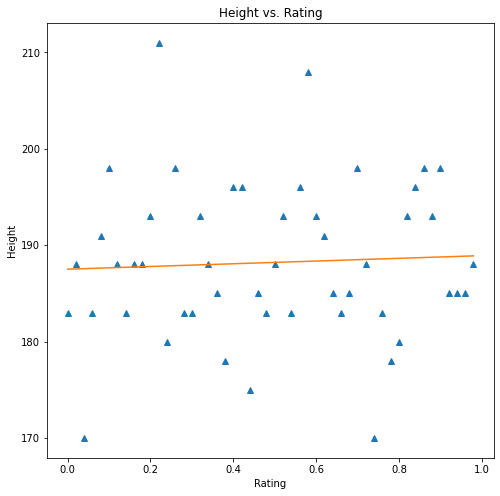

In [7]:
x = player_rank['Rating'].to_numpy()
y = player_rank['Height'].to_numpy()

#regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
line = intercept + slope * x

fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, '^',x,line)
plt.title('Height vs. Rating')
plt.xlabel("Rating")
plt.ylabel("Height")

Text(0, 0.5, 'Age')

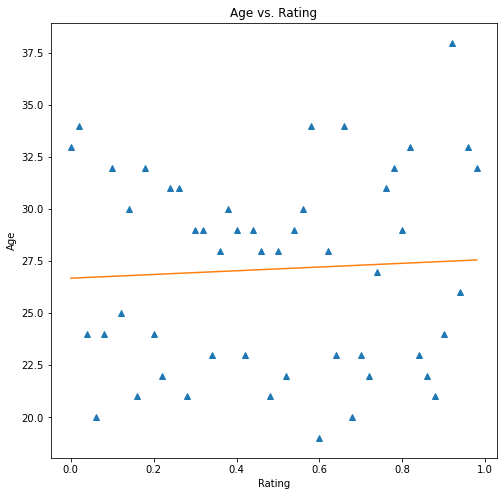

In [8]:
x = player_rank['Rating'].to_numpy()
y = player_rank['Age'].to_numpy()

#regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
line = intercept + slope * x

fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, '^',x,line)
plt.title('Age vs. Rating')
plt.xlabel("Rating")
plt.ylabel("Age")

Text(0, 0.5, 'Tournaments Played')

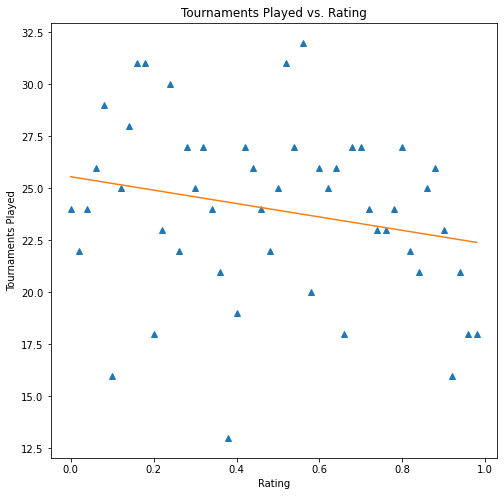

In [9]:
x = player_rank['Rating'].to_numpy()
y = player_rank['Tourn_played'].to_numpy()

#regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
line = intercept + slope * x

fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, '^',x,line)
plt.title('Tournaments Played vs. Rating')
plt.xlabel("Rating")
plt.ylabel("Tournaments Played")

### Observations of Scatter Plots:
- None of the plots show significant correlation and therefore we can assume that height, age, and the number of tournaments played are not impactful on the ranking or rating of a player. 

The second method that we want to use is heatmaps. Heatmaps are useful for our data since we are trying to look at several statistics on both the serves and returns of players. 
We first create a correlation heatmap to see how the various serve attributes correlate to rating and to one another and a separate correlation heatmap to see how various return attributes correlate to rating and one another. 

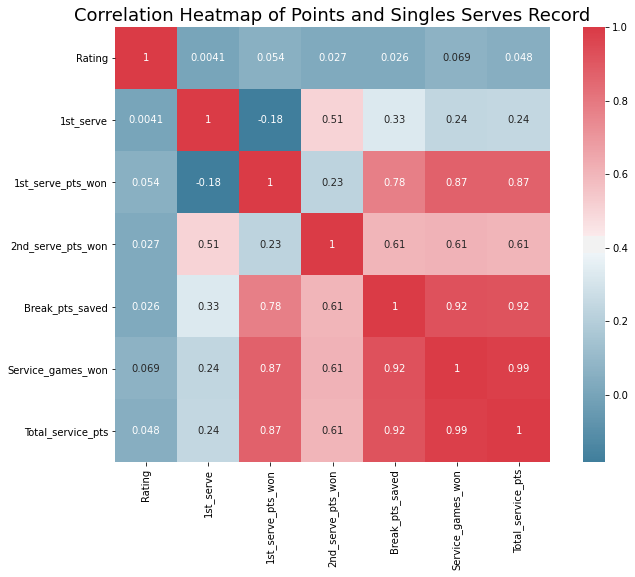

In [10]:
#creating a correlation heatmap for serve statistics
serve_analysis = player_serves[['Rating', '1st_serve', '1st_serve_pts_won', '2nd_serve_pts_won', \
                              'Break_pts_saved', 'Service_games_won', 'Total_service_pts']].copy()
serve_analysis = serve_analysis.corr()

plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Points and Singles Serves Record", fontsize=18)
sns.heatmap(serve_analysis, cmap=sns.diverging_palette(230, 10, as_cmap=True), square=True, annot=True)
plt.show()

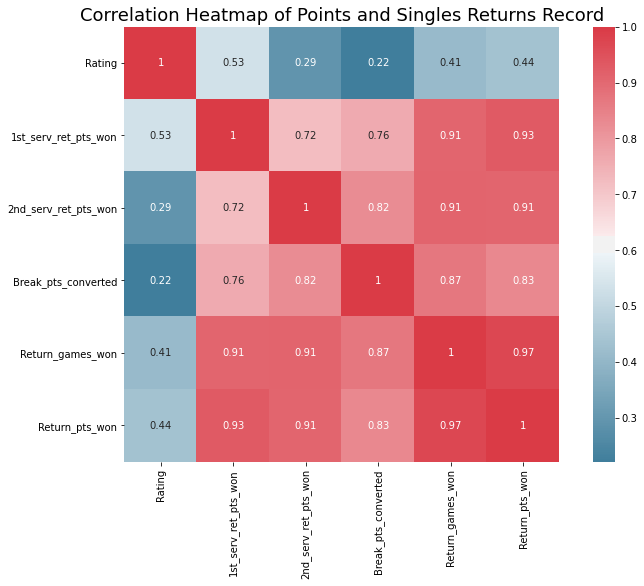

In [11]:
#creating a correlation heatmap for return statistics
return_analysis = player_returns[['Rating', '1st_serv_ret_pts_won', '2nd_serv_ret_pts_won', \
                                 'Break_pts_converted', 'Return_games_won', 'Return_pts_won']].copy()
return_analysis = return_analysis.corr()

plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Points and Singles Returns Record", fontsize=18)
sns.heatmap(return_analysis, cmap=sns.diverging_palette(230, 10, as_cmap=True), square=True, annot=True)
plt.show()

### Observations of Serve and Return Heatmaps: 
#### Serves 
We observe that variables that have the highest correlation with rating are 2nd serve points won and service games won. The serve variables overall have a low correlation with rating compared to the return variables

#### Returns: 
We observe that the variables that have the highest correlation with rating are 1st serve return points won, return games won, and return points won. Four out of the five return variables have higher correlation with rating than the serve variables

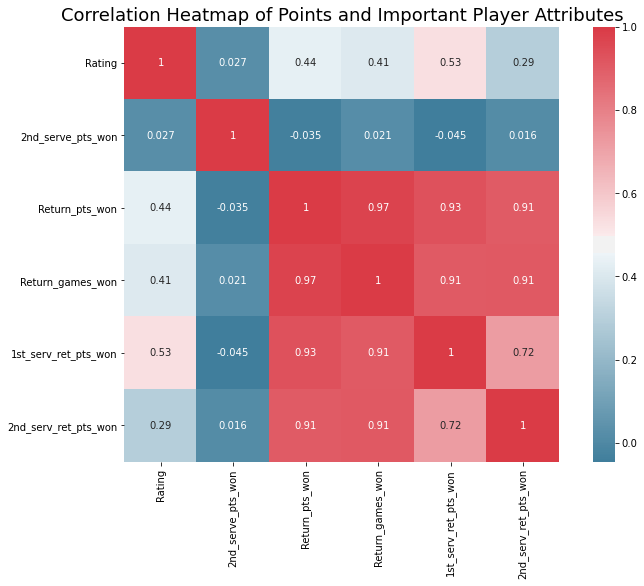

In [12]:
#creating a correlation heatmap for the variables that have the strongest correlation with player rating
serve_attr = player_serves[['Rating','2nd_serve_pts_won']].copy()
return_attr = player_returns[['Rating', 'Return_pts_won', 'Return_games_won', \
                              '1st_serv_ret_pts_won', '2nd_serv_ret_pts_won']].copy()
player_attr = serve_attr.merge(return_attr, how = 'inner', on = 'Rating')

skills_analysis = player_attr.corr()

plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Points and Important Player Attributes", fontsize=18)
sns.heatmap(skills_analysis, cmap=sns.diverging_palette(230, 10, as_cmap=True), square=True, annot=True)
plt.show()

From these two heatmaps, I picked the five attributes or variables that had the highest correlation with player ratings. These were 1st serve return points, return games won, return points won, 2nd serve return points won, and 2nd serve points won. We make a new correlation heatmap for these five skills and use these variables in our next step. 

### Part 4: Hypothesis Testing and Machine Learning

Since we picked five attributes that most strongly correlate with rating, our null hypothesis is: 
None of these five attributes have a noticeable impact on the rating of a player. We use multiple regression to test this null hypothesis and observe the p-value to reject the null hypothesis or not reject the null hypothesis. 

In [13]:
X = player_attr[['2nd_serve_pts_won', 'Return_pts_won', 'Return_games_won', \
                              '1st_serv_ret_pts_won', '2nd_serv_ret_pts_won']]
y = player_attr['Rating']

lm = linear_model.LinearRegression()
model = lm.fit(X, y)

sm_y = y
sm_X = X

sm_X = sm.add_constant(X)

# use ordinary least squares
OLS_model = sm.OLS(y,X).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rating   R-squared (uncentered):                   0.820
Model:                            OLS   Adj. R-squared (uncentered):              0.800
Method:                 Least Squares   F-statistic:                              41.05
Date:                Wed, 22 Jul 2020   Prob (F-statistic):                    1.13e-15
Time:                        02:54:14   Log-Likelihood:                         0.16716
No. Observations:                  50   AIC:                                      9.666
Df Residuals:                      45   BIC:                                      19.23
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
2nd_serve_pts_won       -0.3180      1.447     -0.220      0.827      -3.233       2.597
Return_pts_won          -9.0586     10.539     -0.860      0.395     -30.285      12.168
Return_games_won         1.2215      1.829      0.668      0.508      -2.463       4.906
1st_serv_ret_pts_won    11.9643      6.557      1.825      0.075      -1.241      25.170
2nd_serv_ret_pts_won     0.5869      4.807      0.122      0.903      -9.094      10.268
==============================================================================
Omnibus:                        1.022   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                1.082
Skew:                          -0.287   Prob(JB):                        0.582
Kurtosis:                       2.565   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we look at the p-values for each attribute, we can see that the p-values are above 0.05 for every attribute except for 1st serve return points won. We reject the null hypothesis since from our data we can see that at least one of the attributes, 1st serve return points won impacts the rating of a player. 

We now want to fit a model to see if we can predict the rating of a player using these five attributes. We have to split the data into a training and test set before we fit it. We can then get predicted values and compare them with the actual values.

In [14]:
# create training and testing data from X and Y used above
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.3)

model = lm.fit(X_train, y_train)

# generate predictions for player rating to compare with y_test data
predictions = lm.predict(X_test)

predictions[0:10]

array([0.4979604 , 0.5822504 , 0.44088129, 0.51502557, 0.68315161,
       0.44657344, 0.52165408, 0.41637455, 0.25981506, 0.40032098])

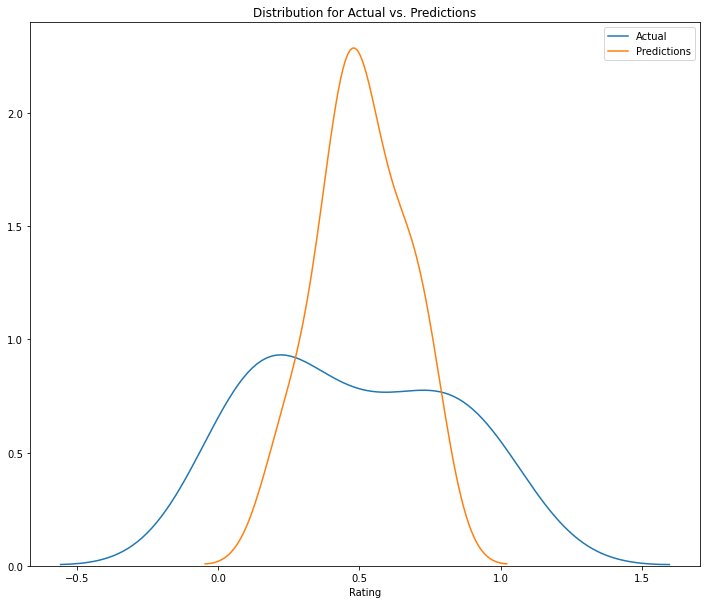

In [15]:
#map actual values versus prediction and then observe the r^2 value
f, ax = plt.subplots(figsize=(12,10))
plt.title('Distribution for Actual vs. Predictions')
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(predictions, hist=False, label="Predictions", ax=ax)

In [16]:
model.score(X_test, y_test)

0.40814864099699366

We can calculate the accuracy of this model with the R^2 value. At 1, the model fits the data exactly and at 0, the model has no meaningful predictive value. We can see that it is closer to 0 than 1 which makes sense since we observed that four out of the five attributes do not significantly impact the rating of a player. This means that this model is not meaningful in predicting the rating of a player. 

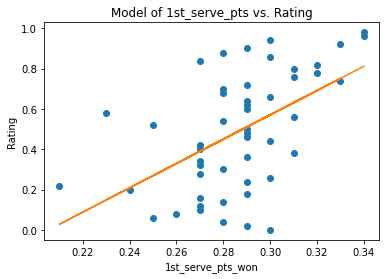

In [17]:
a = player_attr['1st_serv_ret_pts_won'].to_numpy().reshape(-1,1)
b = player_attr['Rating']

#linear regression model
lm.fit(a,b)
predicted = lm.predict(a)

plt.plot(a,b,'o')
plt.plot(a, predicted)
plt.title("Model of 1st_serve_pts vs. Rating")
plt.xlabel("1st_serve_pts_won")
plt.ylabel("Rating")
plt.show()

In [18]:
lm.score(a, b)

0.2833196005171641

Since we only have one attribute that has a significant impact on the rating, we can create a linear regression model using that attribute. We also need a measure of how well our line represents the data, and so we look at the R^2 value which lies between 0 and 1. 

The R^2 value here is much closer to 0 than it is 1. This means that the attribute is not a good model to predict the rating of a player. 

### Part 5: Conclusions and Insights

In this tutorial, we went through the five steps of the data life cycle while analyzing the data on the top 50 ranked tennis players around the world. From this data, we were able to visualize our data and test a hypothesis to check whether we can find attributes that are common among the best tennis players. We chose to reject the null hypothesis that none of the attributes we observed have an impact on the rating of the player. However, our linear regression models and predictive models showed that these attributes are still not meaningful enough to predict the rating of a player or claim that there is a significant relationship between any of these serving or return statistics and player ratings. 

While we were not able to find significant observations about what exactly makes a tennis player the best, I hope this tutorial was useful. If you are interested in the statistical analysis of tennis, this is a great article that can provide more information on its role in tennis today: 
https://www.tennis.com/pro-game/2020/01/analytics-tennis-long-slow-rise-djokovic-federer-moya-andreescu/86128/ 